In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [2]:
train  =  pd.read_csv('dengue_features_train.csv', parse_dates=[3])
test = pd.read_csv('dengue_features_test.csv', parse_dates=[3])
full_df = pd.concat([train, test], axis = 0)

all_sj  =  full_df[full_df['city']  ==  'sj']
all_iq  =  full_df[full_df['city']  ==  'iq']


df_sj = all_sj.fillna(method = 'ffill')
df_iq = all_iq.fillna(method = 'ffill')

In [3]:
# set index to the dates
df_sj.set_index('week_start_date', drop = True, inplace = True)
df_iq.set_index('week_start_date', drop = True, inplace = True)

In [4]:
#drop non-numerical values
df_sj.drop(['city', 'year'], axis = 1, inplace = True)
df_iq.drop(['city', 'year'], axis = 1, inplace = True)

In [5]:
total_cases = pd.read_csv('dengue_labels_train.csv')
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

In [6]:
# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

In [7]:
# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0


In [8]:
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

In [9]:
# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test


In [10]:
print (len(sj_train), len(sj_Xtrain), len(sj_ytrain))
print (len(sj_valid), len(sj_Xvalid), len(sj_yvalid))
print (len(sj_test), len(sj_Xtest))

675 675 675
261 261 261
260 260


In [11]:
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' 

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test

# check the lengths
print (len(iq_train), len(iq_Xtrain), len(iq_ytrain))
print (len(iq_valid), len(iq_Xvalid), len(iq_yvalid))
print (len(iq_test), len(iq_Xtest))

print (len(pd.get_dummies(sj_Xtrain['month'], prefix='month')), len(sj_ytrain.values))
print (len(pd.get_dummies(sj_Xvalid['month'], prefix='month')), len(sj_yvalid.values))
print(pd.get_dummies(sj_Xtrain['month']))
# sj monthly trend


364 364 364
156 156 156
156 156
675 675
261 261
                 1   2   3   4   5   6   7   8   9   10  11  12
week_start_date                                                
1990-04-30        0   0   0   1   0   0   0   0   0   0   0   0
1990-05-07        0   0   0   0   1   0   0   0   0   0   0   0
1990-05-14        0   0   0   0   1   0   0   0   0   0   0   0
1990-05-21        0   0   0   0   1   0   0   0   0   0   0   0
1990-05-28        0   0   0   0   1   0   0   0   0   0   0   0
1990-06-04        0   0   0   0   0   1   0   0   0   0   0   0
1990-06-11        0   0   0   0   0   1   0   0   0   0   0   0
1990-06-18        0   0   0   0   0   1   0   0   0   0   0   0
1990-06-25        0   0   0   0   0   1   0   0   0   0   0   0
1990-07-02        0   0   0   0   0   0   1   0   0   0   0   0
1990-07-09        0   0   0   0   0   0   1   0   0   0   0   0
1990-07-16        0   0   0   0   0   0   1   0   0   0   0   0
1990-07-23        0   0   0   0   0   0   1   0   0   0 

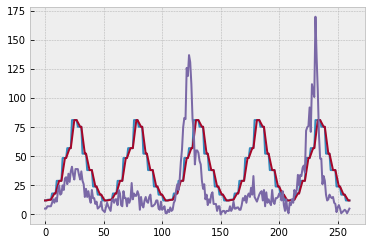

24.455938697318008
25.27905491698595


In [12]:
lr_sj = LinearRegression()
X = pd.get_dummies(sj_Xtrain['month'], prefix='month')
y = sj_ytrain.values

lr_sj.fit(X, y)
monthly_trend_train = pd.Series(lr_sj.predict(X)).rolling(3, min_periods = 1).mean()
sj_residuals_train = y - monthly_trend_train


Xtest = pd.get_dummies(sj_Xvalid['month'], prefix='month')
ytest = sj_yvalid.values
monthly_trend_valid = pd.Series(lr_sj.predict(Xtest)).rolling(3, min_periods=1).mean()
sj_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_sj.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print( mean_absolute_error(lr_sj.predict(Xtest), ytest))
print (mean_absolute_error(monthly_trend_valid, ytest))

-16.168582375478927
675 261


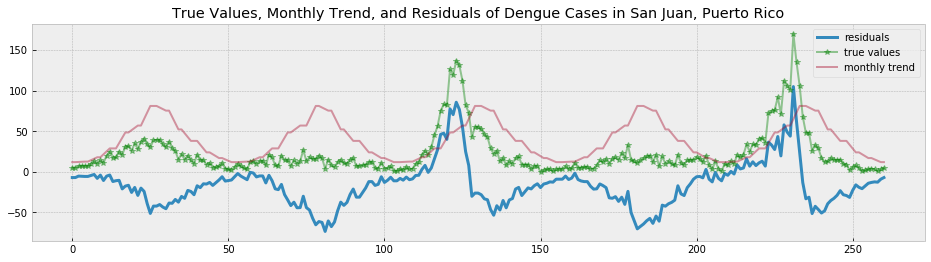

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(sj_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in San Juan, Puerto Rico')
plt.legend()
print (np.mean(sj_residuals_test))

print (len(sj_residuals_train), len(sj_residuals_test))

In [14]:
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:675]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[60:675]


Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_train[60:]

print (len(Xtrain), len(ytrain))

615 615


201 201
25.546367453036282
-0.10694482922522842
364 364
156 156


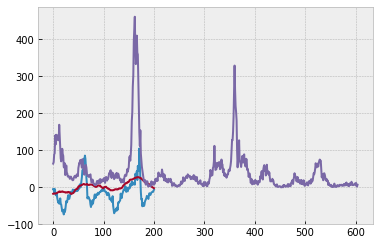

In [15]:
Xvalid_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[675:936]
Xvalid_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[675:936]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = sj_residuals_test[60:]

print (len(Xvalid), len(yvalid))

# fit on model, predict
lr_sj_residual = LinearRegression()
lr_sj_residual.fit(Xtrain, ytrain)

sj_valid_preds = lr_sj_residual.predict(Xvalid)

print (mean_absolute_error(sj_valid_preds, yvalid))
print (lr_sj_residual.score(Xvalid, yvalid))
plt.plot(yvalid.values)
plt.plot(sj_valid_preds)


print (len(pd.get_dummies(iq_Xtrain['month'], prefix='month')), len(iq_ytrain.values))
print (len(pd.get_dummies(iq_Xvalid['month'], prefix='month')), len(iq_yvalid.values))


plt.plot(y[70:])


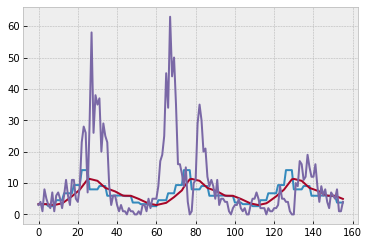

7.063351362179487
6.930721893124237


In [16]:

# iq monthly trend

lr_iq = LinearRegression()
X = pd.get_dummies(iq_Xtrain['month'], prefix='month')
y = iq_ytrain.values

lr_iq.fit(X, y)
monthly_trend_train = pd.Series(lr_iq.predict(X)).rolling(9, min_periods = 1).mean()
iq_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(iq_Xvalid['month'], prefix='month')
ytest = iq_yvalid.values
monthly_trend_valid = pd.Series(lr_iq.predict(Xtest)).rolling(9, min_periods=1).mean()
iq_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_iq.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print (mean_absolute_error(lr_iq.predict(Xtest), ytest))
print (mean_absolute_error(monthly_trend_valid, ytest))

3.4333689856150795
304 304


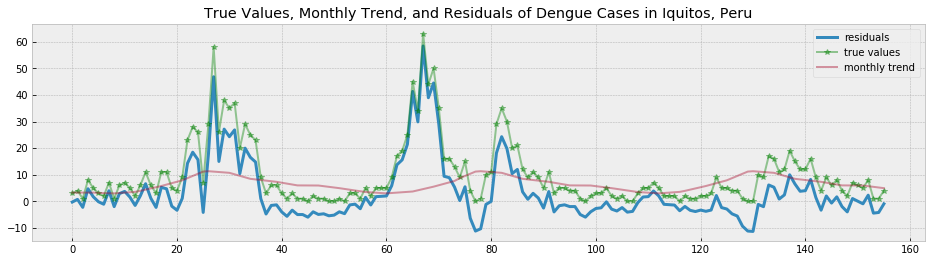

In [17]:

# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(iq_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in Iquitos, Peru')
plt.legend()
print (np.mean(iq_residuals_test))


len(Xtrain)
len(ytrain)

# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:364]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_train[60:]

print(len(Xtrain), len(ytrain))

201 96


ValueError: Found input variables with inconsistent numbers of samples: [96, 201]

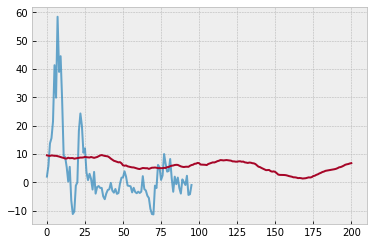

In [18]:
# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = iq_residuals_test[60:]

print (len(Xvalid), len(yvalid))

# model it!

lr_iq_resids = LinearRegression()
lr_iq_resids.fit(Xtrain, ytrain)

iq_valid_preds = lr_iq_resids.predict(Xvalid)

# plot iq residual predictions
plt.plot(yvalid.values, alpha = .75)
plt.plot(iq_valid_preds)
print( lr_iq_resids.score(Xvalid, yvalid))
print (mean_absolute_error(iq_valid_preds, yvalid))


876
876
25.74361520998865


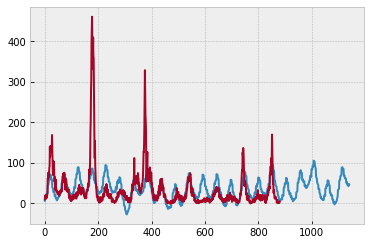

In [19]:
# transform sj data

month_dums = pd.get_dummies(df_sj['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_sj[['station_avg_temp_c']].rolling(window = 55).mean())
# temp_roll_std = pd.DataFrame(df_sj[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test set
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)
print(len(Xtest[60:-260]))
print(len(cases_sj.values[60:]))
# train model
lr_sj_full = LinearRegression()
lr_sj_full.fit(Xtest[60:-260], cases_sj.values[60:])

# predicts
sj_full_preds = lr_sj_full.predict(Xtest[55:])
sj_submit_preds = sj_full_preds[-260:]


plt.plot(sj_full_preds)
plt.plot(cases_sj.values[55:])
print (mean_absolute_error(sj_full_preds[:-260], cases_sj.values[55:]))


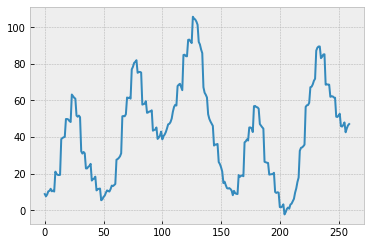

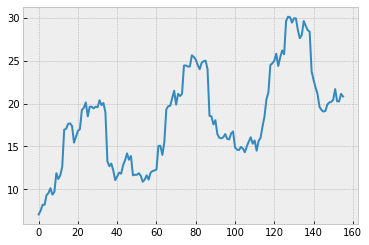

In [20]:
# transform iq data
month_dums = pd.get_dummies(df_iq['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_iq[['ndvi_nw']].rolling(window = 68).mean())
# temp_roll_std = pd.DataFrame(df_iq[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train
lr_iq_full = LinearRegression()
lr_iq_full.fit(Xtest[68:-156], cases_iq.values[68:])

# predicts
iq_full_preds = lr_iq_full.predict(Xtest[68:])
iq_submit_preds = iq_full_preds[-156:]

plt.plot(sj_submit_preds)
plt.show()
plt.plot(iq_submit_preds)
plt.show()


total_preds = list(sj_submit_preds) + list(iq_submit_preds)


In [22]:
# submission
submission_format = pd.read_csv('SubmissionFormat.csv')
submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [23]:
 #get monthly trend of whole test df
lr_sj_month = LinearRegression()
X_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = cases_sj.values

lr_sj_month.fit(X_months, y)
monthly_trend = pd.Series(lr_sj_month.predict(X_months)).rolling(3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[60:936]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[60:936]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[936:]
Xtest_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[936:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

# fit on model
lr_sj_resid = LinearRegression()
lr_sj_resid.fit(Xtrain, ytrain)



# make predictions on monthly data and residual data
sj_monthly_preds = pd.Series(lr_sj_month.predict(Xtest_months)).rolling(3, min_periods=1).mean()
sj_resid_preds = lr_sj_resid.predict(Xtest_weather)
sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))


In [24]:

### make plot of best model predictions and actual cases over all time period for sj

# monthly trend
sj_month_preds = lr_sj_month.predict(pd.get_dummies(df_sj['month'], prefix='month'))


# predicted residuals
weather1 = df_sj[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_sj[['ndvi_se']].rolling(window=10, min_periods=1).mean()
weather_all = pd.concat([weather2], axis = 1)
sj_resid_predicts = lr_sj_resid.predict(weather_all)


# monthly + residuals
pred_cases = pd.Series(sj_month_preds + sj_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)


len(cases_iq)

520

In [25]:
# get monthly trend of whole test df
lr_iq_month = LinearRegression()
X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

lr_iq_month.fit(X_months, y)
monthly_trend = pd.Series(lr_iq_month.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:520]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[520:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

In [26]:
# fit on model
lr_iq_resid = LinearRegression()
lr_iq_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(lr_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = lr_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))




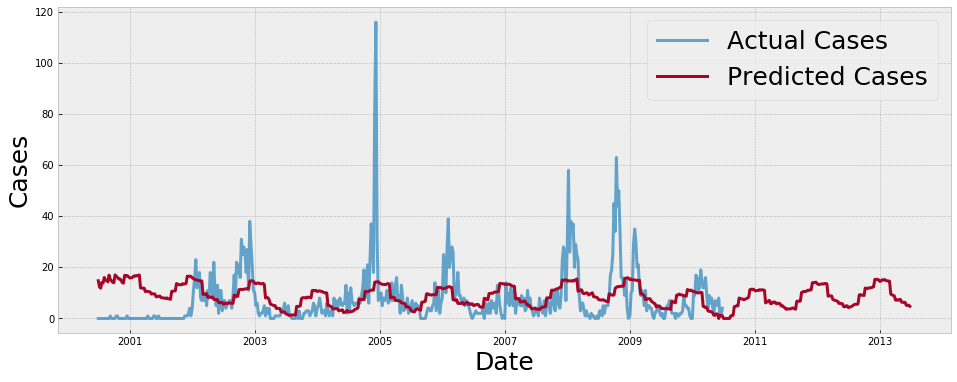

In [28]:
# monthly trend
iq_month_preds = lr_iq_month.predict(pd.get_dummies(df_iq['month'], prefix='month'))
# predicted residuals
weather1 = df_iq[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_iq[['ndvi_se']].rolling(window=10, min_periods=1).mean()
weather_all = pd.concat([weather1], axis = 1)
iq_resid_predicts = lr_iq_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(iq_month_preds + iq_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_iq.index[:520], cases_iq, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_iq.index, pred_cases, label = 'Predicted Cases', linewidth = 3)

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)


total_preds = list(sj_cases_pred) + list(iq_cases_pred)


In [29]:
# submission
submission_format = pd.read_csv('SubmissionFormat.csv')

submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: math.floor(x))


submission_format2 = pd.read_csv('dengue_submission_final2.csv')


# Save to CSV, use current date
submission_format.to_csv('dengue_submission_final2.csv', index=False)

submission_format.head()

FileNotFoundError: File b'dengue_submission_final2.csv' does not exist